# Структура анализа
### 1. Сбор данных
### 2. Подготовка данных для анализа
### 3. Анализ

<font color=red>Не запускайте код в 1-2 разделах. Он представлен в качестве мета кода, для демонстрации концептов или для приведения примеров</font>


# 1. Сбор данных

### API
После экспериментов с API Comtrade выявлена оптимальная структура запросов:
- Докладчики - индивидуальный код
- Партнеры - все
- Календарное значение агрегации - год
- Код экономической деятельности - 4
    - 6-значные коды дают результаты, превышающие лимиты API
    - 2-значные коды не содержат полные данные по объему поставки
- Максимальное количество записей - 100к
    - Выходные данные по таким странам как Германия составили 54к наблюдений по всем группам товаров за 2017 год.
    - Все остальные страны скорее всего не привысят лимит.
- Все наименования товаров

### SQL - AWS PostgreSQL 
#### доступ к базе данных - в будущем по требованию

- Создана облачная база данных в которую записываются результаты API запросов.
- Таким образом не является необходимым делать новые API запросы на повторяющиеся условия анализа (одинаковые 
    календарные периоды, страны и т.д.)

### Данные в свободном доступе 
Следующие таблицы представлены Comtrade 

###### Коды наименований товаров

In [ ]:
comtrade=> select * from commodity_codes_en limit 5;
  id  |                     commodity_name                     
------+--------------------------------------------------------
 0402 | Milk and cream, concentrated or containing added sugar
 0403 | Buttermilk, curdled milk and cream or yogurt
 0406 | Cheese and curd.
 0407 | Birds' eggs, in shell, fresh, preserved or cooked.
 0409 | Natural honey.

In [ ]:
comtrade=> select count(*) from commodity_codes_en;
 count 
-------
  1227

###### Торговые партнеры

In [ ]:
comtrade=> select * from partners limit 5;
 id  |       partner_name       
-----+--------------------------
   0 | World
   4 | Afghanistan
 472 | Africa CAMEU region, nes
   8 | Albania
  12 | Algeria

In [ ]:
comtrade=> select count(*) from partners;
 count 
-------
   292

###### Другие таблицы
Также добавлены таблицы докладывающих стран, торговых режимов и русский перевод 
наименований товаров с группами товаров.

Кроме того создана свобдная таблица отчетности на данный момент содержащая 160к рядов.
Каждый ряд - доклад страны по импорту конкретного наименования (4-значный код) за отчетный год.


In [ ]:
comtrade=> select * from commodity_codes_ru limit 5;
   id   |                  commodity_name                  |      product_group      
--------+--------------------------------------------------+-------------------------
 01     | Живые животные                                   | прочая сельхозпродукция
 0101   | Лошади, ослы и их помеси                         | прочая сельхозпродукция
 010110 | Чистопородные племенные лошади, ослы и их помеси | прочая сельхозпродукция
 010121 | Чистопородные племенные лошади                   | прочая сельхозпродукция
 010129 | Лошади обычные                                   | прочая сельхозпродукция

In [ ]:
comtrade=> select count(*) from trade_aggregation_entries;
 count  
--------
 163137

###### Обобщение составленных таблиц

In [ ]:
comtrade=> SELECT                                  
   relname as "Table",
   pg_size_pretty(pg_total_relation_size(relid)) As "Size",
   pg_size_pretty(pg_total_relation_size(relid) - pg_relation_size(relid)) as "External Size"
   FROM pg_catalog.pg_statio_user_tables ORDER BY pg_total_relation_size(relid) DESC;
           Table           |  Size   | External Size 
---------------------------+---------+---------------
 trade_aggregation_entries | 34 MB   | 15 MB
 commodity_codes_ru        | 1256 kB | 216 kB
 commodity_codes_en        | 264 kB  | 88 kB
 reporters                 | 80 kB   | 64 kB
 partners                  | 80 kB   | 64 kB
 quantity_codes            | 48 kB   | 40 kB
 trade_regimes             | 48 kB   | 40 kB
 partner_iso               | 24 kB   | 24 kB
 reporter_iso              | 24 kB   | 24 kB

In [ ]:
### Следующие шаги

Выявлен существенный bottleneck добавления новых записей в таблицы SQL на уровне Pandas.
Не смотря на то, что не использованы петли (loops), а apply - задержки в добавлении записей существенны для SQL.

## Недостаточно данных

Из-за указанной проблемы удалось собрать только данные по трем странам, не входящим в Европейский регион.
С другой стороны - создана система API запросов, автоматически направляющих данные в SQL базу данных для 
долгосрочного использования.

Возможно рассмотрение хранения полученных по API запросам данных для упрощения задачи в будущем.

<font color=red> ## Задание выполнено лишь в части </font>

# 2. Подготовка данных для анализа

### Загрузка библиотек
#### - Основные библиотеки для работы с данными (время, данные, запросы)
#### - Загрузка, чтение данных и файловая навигация
#### - SQL Alchemy - работа с базами данных

In [1]:
import datetime
import pandas as pd
import requests
import time

import json
import os

from sqlalchemy.orm import sessionmaker
from sqlalchemy import create_engine
from sqlalchemy.ext.declarative import declarative_base
from sqlalchemy import Column, Integer, String, Enum, ForeignKey, BigInteger
from sqlalchemy.dialects.postgresql import TEXT, VARCHAR, INTEGER
from sqlalchemy.dialects.postgresql import TIMESTAMP, ARRAY
from sqlalchemy import Boolean
from sqlalchemy import desc
from sqlalchemy import UniqueConstraint
from sqlalchemy.sql import select
from sqlalchemy.sql import exists

import pkg_resources

### Загрузка данных в таблицу
Запуск этой ячейки не даст результатов, т.к. модуль **credentials** исключен из начтоящего репозитория. В нем содержатся пароли к личным облачным сервисам, на одном из которых расположена база данных

In [2]:
json_path = pkg_resources.resource_filename('credentials', 'passwords.json')
data = json.load(open(json_path))
dataslap_postgres = data["aws"]["personal"]["dataslap"]["postgres"]["free_20gb"]["dataslap_user"]
engine_test = create_engine('postgres://%(username)s:%(password)s@%(host)s:%(port)s/comtrade' %
                            {"username": dataslap_postgres["username"],
                             "password": dataslap_postgres["password"],
                             "host": dataslap_postgres["host"],
                             "port": dataslap_postgres["port"]})
Base_item = declarative_base()

### Классы SQL таблиц
**SQL Alchemy** использует ORM для декларирования структуры таблиц.
Ниже представлены структуры таблиц используемых для анализа, остальные таблицы исключены. 
Базовая информация о таблицах была представлена ранее.
У каждого класса (таблицы) стандартная 3NF структура, в большинстве случаев у таблицы два поля - id (первичный ключ) и основное поле. 
**Id** в большинстве случаев взяты напрямую из API Comtrade для облегчения объединения таблиц и упрощения сбора данных - таким образом сырые данные API используются для добавления данных в таблицы без существенных изменений.

**Id** представлены в формате числа кроме кодов товаров - так как там присутствует ноль в начале кода.

**Trade_aggregation_entry** - основная сводная таблица с внешними ключами в качестве привязок к другим таблицам. Bigint использован для отображения численных торговых агрегаций.

In [3]:
class Reporter(Base_item):
    __tablename__ = "reporters"
    id = Column(INTEGER, primary_key=True)
    reporter_name = Column(TEXT, unique=True)

    def __repr__(self):
        return "<Reporter(id='%s', reporter_name='%s')>"\
            % (self.id, self.reporter_name)

class Partner(Base_item):
    __tablename__ = "partners"
    id = Column(INTEGER, primary_key=True)
    partner_name = Column(TEXT, unique=True)

    def __repr__(self):
        return "<Partner(id='%s', partner_name='%s')>"\
            % (self.id, self.partner_name)
    
class Trade_regimes(Base_item):
    __tablename__ = "trade_regimes"
    id = Column(INTEGER, primary_key=True)
    trade_regime_name = Column(TEXT, unique=True)

    def __repr__(self):
        return "<Trade_regime(id='%s', trade_regime_name='%s')>"\
            % (self.id, self.trade_regime_name)
    
class Commodity_code_RU(Base_item):
    __tablename__ = "commodity_codes_ru"
    id = Column(String(6), primary_key=True)
    commodity_name = Column(TEXT, unique=False)
    product_group = Column(TEXT, unique=False)

    def __repr__(self):
        return "<Commodity_code_RU(id='%s', commodity_name='%s', product_group='%s')>"\
            % (self.id, self.commodity_name, self.product_group)
    
    
class Quantity_code(Base_item):
    __tablename__ = "quantity_codes"
    id = Column(INTEGER, primary_key=True)
    quantity_name = Column(TEXT, unique=True)

    def __repr__(self):
        return "<Quantity_code(id='%s', quantity_name='%s')>"\
            % (self.id, self.quantity_name)
    
class Trade_aggregation_entry(Base_item):
    __tablename__ = "trade_aggregation_entries"
    id = Column(BigInteger, primary_key=True)

    pf_code = Column(String(6), unique=False)

    year = Column(Integer)
    period = Column(Integer)
    period_description = Column(TEXT)

    aggregation_level = Column(Integer)

    trade_regime = Column(INTEGER, ForeignKey("trade_regimes.id"), nullable=False)
    reporter = Column(INTEGER, ForeignKey("reporters.id"), nullable=False)
    partner = Column(INTEGER, ForeignKey("partners.id"), nullable=False)
    commodity = Column(String(6), ForeignKey("commodity_codes_en.id"), nullable=False)
    quantity_code = Column(INTEGER, ForeignKey("quantity_codes.id"), nullable=False)

    trade_quantity = Column(BigInteger)
    net_weight = Column(BigInteger)
    trade_value = Column(BigInteger)

    __table_args__ = (UniqueConstraint('period', 'trade_regime',
                                        'reporter', 'partner',
                                        'commodity',name='_trade_entry'),
                     )


    def __repr__(self):
        return "<Trade_aggregation_entry(id='%s', pf_code='%s', year='%s', period='%s',\
                    period_description='%s', aggregation_level='%s', trade_regime='%s',\
                    reporter='%s', partner='%s', commodity='%s',\
                    quantity_code='%s', trade_quantity='%s',\
                    net_weight='%s', trade_value='%s')>"\
        % (self.id, self.pf_code, self.year, self.period, self.period_description, self.aggregation_level,
            self.trade_regime, self.reporter, self.partner, self.commodity,
            self.quantity_code, self.trade_quantity, self.net_weight, self.trade_value)

### Создание сессии для SQL запросов

In [4]:
Base_item.metadata.create_all(engine_test)
Session_test = sessionmaker(bind=engine_test)
session_test = Session_test()

### Основной запрос и объединение (join) таблиц

In [5]:
q = (session_test.query(Trade_aggregation_entry, Trade_regimes, Reporter, Partner, Commodity_code_RU, Quantity_code)
    .join(Trade_regimes, Trade_aggregation_entry.trade_regime == Trade_regimes.id)
    .join(Reporter, Trade_aggregation_entry.reporter == Reporter.id)
    .join(Partner, Trade_aggregation_entry.partner == Partner.id)
    .join(Commodity_code_RU, Trade_aggregation_entry.commodity == Commodity_code_RU.id)
    .join(Quantity_code, Trade_aggregation_entry.quantity_code == Quantity_code.id).all())

### Функция перевода данных запросов в словари Python

In [6]:
def inst_to_dict(inst, delete_id=True):
    dat = {}
    for column in inst.__table__.columns:
        dat[column.name] = getattr(inst, column.name)
    # if delete_id:
    #     dat.pop("num")
    return dat

### Сведение в финальную таблицу для анализа и запись в csv таблицу
Отброшены столбцы содержащие **id** из соединенных таблиц.
Дополнительно задан порядок столбцов для лучшего визуального восприятия.

In [7]:
aggregations = pd.DataFrame([inst_to_dict(i[0]) for i in q])
regimes = pd.DataFrame([inst_to_dict(i[1]) for i in q]).drop("id", axis = 1)
reporters = pd.DataFrame([inst_to_dict(i[2]) for i in q]).drop("id", axis = 1)
partners = pd.DataFrame([inst_to_dict(i[3]) for i in q]).drop("id", axis = 1)
commodities = pd.DataFrame([inst_to_dict(i[4]) for i in q]).rename(columns={'id':'ТНВЭД'})
quantities = pd.DataFrame([inst_to_dict(i[5]) for i in q]).drop("id", axis = 1)

final_data = pd.concat([aggregations, regimes, reporters, partners, commodities, quantities], axis = 1)

final_data = final_data.drop(["aggregation_level", "id", "period_description", 
                 "pf_code", "quantity_code", "reporter", "trade_regime", "period", "partner", "commodity"], axis = 1)

final_data = final_data.loc[:,["year", "reporter_name",  "partner_name", "trade_regime_name",
           "ТНВЭД", "commodity_name", "product_group", "quantity_name",
          "trade_quantity", "net_weight", "trade_value"]]

### Фильтрация торгового партнера "World"
**World** содержит общую сумму торговых операций от всех партнеров. Так как в данном анализе будет рассматриваться импортная деятельность всех торговых партнеров, данные с **World** не представляют ценности для данного анализа.

Фильтрованная таблица записана на диск и используется для основного анализа.

In [8]:
final_data.loc[final_data["partner_name"] != "World",:].to_csv("final_comtrade.csv", index = False)

# 3. Анализ

#### Загрузка базы данных, сформированной в предыдущих секциях

In [9]:
read_final = pd.read_csv("final_comtrade.csv", index_col = False, dtype={'ТНВЭД': object})

In [10]:
read_final.head()

,year,reporter_name,partner_name,trade_regime_name,ТНВЭД,commodity_name,product_group,quantity_name,trade_quantity,net_weight,trade_value
0,2016,Afghanistan,Belgium,Import,0402,Молоко и сливки концентрированные,готовое продовольствие,Weight in kilograms,243459,243459,254254
1,2016,Afghanistan,China,Import,0402,Молоко и сливки концентрированные,готовое продовольствие,Weight in kilograms,159285,159285,110752
2,2016,Afghanistan,Denmark,Import,0402,Молоко и сливки концентрированные,готовое продовольствие,Weight in kilograms,77958,77958,91419
3,2016,Afghanistan,France,Import,0402,Молоко и сливки концентрированные,готовое продовольствие,Weight in kilograms,2233348,2233348,1934260
4,2016,Afghanistan,Iran,Import,0402,Молоко и сливки концентрированные,готовое продовольствие,Weight in kilograms,2538333,2538333,1774192


#### Выбор стран для анализа
Так как были загружены только 3 страны (частично), анализ будет проведен на примере одной страны , группе из двух стран и всех стран как "синтетического" региона для демонстрации. Такая группировка является абсолютно искуственной.

Были загружены следующие страны: Афганистан, Албания, Алжир
###### **UPD** Для построения графика загружены новые данные. Т.к. агрегатор данных с API работал и после направления файла 
###### задания, в базе данных охвачен более широкий диапазон стран, чем в изначальном файле. Пожалуйста игнорируйте расхождения.

In [13]:
read_final["reporter_name"].unique().tolist()

['Afghanistan', 'Albania', 'Algeria', 'Andorra', 'Angola']

#### Объем импорта всех наименований товаров по характерному количеству
Каждое наименование товаров измеряется в соответствующей системе. Из отраженных в данный момент в базе данных измерений представленны следующие:

In [14]:
read_final["quantity_name"].unique().tolist()

['Weight in kilograms',
 'No Quantity',
 'Volume in litres',
 'Number of items',
 'Number of pairs',
 'Electrical energy in thousands of kilowatt-hours',
 'Volume in cubic meters',
 'Area in square metres',
 'Length in metres',
 'Weight in carats']

###### Данные фильтруются на "No quantity"

In [21]:
import_volume_slice_num = read_final.loc[read_final.quantity_name != "No Quantity",["year", "reporter_name", 
                                                                         "ТНВЭД", "commodity_name", 
                                                                        "quantity_name", "trade_quantity"]]

trade_code_labels = read_final.loc[:,["ТНВЭД", "commodity_name", "product_group"]].drop_duplicates().fillna("")
trade_code_labels.index = trade_code_labels["ТНВЭД"]
trade_code_labels = trade_code_labels.drop("ТНВЭД", axis = 1)

trade_quantity_aggr =\
pd.DataFrame(import_volume_slice_num.\
            loc[import_volume_slice_num["quantity_name"] != "Quantity",:].\
            groupby(["quantity_name", "ТНВЭД"])["trade_quantity"].\
            sum()).\
            join(trade_code_labels).\
            set_index('trade_quantity', append=True).\
            sort_index(level = [0, 2], ascending=False).reset_index(level=2)

trade_quantity_aggr.columns = ["Количество импорта", "Наименование товара", "Группа товара"]

trade_quantity_aggr.to_csv("Агрегация товаров по количеству")

trade_quantity_aggr

Количество импорта  \
quantity_name                                    ТНВЭД                       
Weight in kilograms                              1001          54696963449   
                                                 2710          25234177671   
                                                 1005          25017194533   
                                                 2523          24531050034   
                                                 7214          20675763749   
                                                 6801          18657448103   
                                                 4811          14575990310   
                                                 1701          14162548692   
                                                 1101          10421714824   
                                                 2703           8311050615   
                                                 2304           8297081851   
                                                 2713           5760760774   
                                                 1507           4093879305   
                                                 7213           3889539865   
                                                 2711           3810549953   
                                                 7208           3143031254   
                                                 1003           3058957275   
                                                 7304           2873837624   
                                                 7216           2868411718   
                                                 0402           2741523536   
                                                 7306           2564860186   
                                                 2704           2536847402   
                                                 7207           2349211103   
                                                 7308           2323551243   
                                                 2836           2220555662   
                                                 2505           2083975611   
                                                 0803           2028977608   
                                                 3901           1957340338   
                                                 0713           1887089433   
                                                 2517           1710802590   
...                                                                    ...   
Number of items                                  8904                   18   
                                                 6210                   13   
                                                 9404                   12   
                                                 8453                   11   
                                                 9204                    7   
                                                 8605                    6   
                                                 8451                    6   
                                                 9112                    4   
                                                 8455                    4   
                                                 9110                    2   
                                                 8434                    2   
                                                 8410                    2   
                                                 8486                    1   
                                                 8441                    0   
                                                 8413                    0   
Length in metres                                 3706               258008   
Electrical energy in thousands of kilowatt-hours 2716             18568471   
Area in square metres                            6908            279766663   
                                                 6907             46041626   


### Объем импорта за 2016-2017 год
Определяем интересующий временной период и столбцы, испольщуемые для вычислений.
Дополнительно создаем таблицу расшифровки кодов ТНВЭД из эстетических соображений визуализации таблицы.

In [22]:
import_volume_slice = read_final.loc[read_final.year.isin([2016, 2017]),["year", "reporter_name", 
                                                                         "ТНВЭД", "commodity_name",
                                                                        "product_group", "trade_value"]]

#### Объем импорта за 2016-2017 г. в Афганистане по наименованию товара

In [23]:
one_country_total_value_import =\
            pd.DataFrame(import_volume_slice.\
            loc[import_volume_slice["reporter_name"] == "Afghanistan",:].\
            groupby("ТНВЭД")["trade_value"].\
            sum().\
            sort_values(ascending = False)).\
            join(trade_code_labels, how = "left")

one_country_total_value_import.columns = ["Объем импорта, в ден. выражении", "Наименование товара", "Группа товаров"]
one_country_total_value_import

,"Объем импорта, в ден. выражении",Наименование товара,Группа товаров
ТНВЭД,,,
9999,2342430530,Неклассифицированные товары,
1101,664062344,Пшеничная мука,зерно и продукты перемола
2703,598169115,Торф,
5808,334519589,"Тесьма, отделочные материалы в куске и схожие ...",текстильные материалы и изделия
1518,316489768,Непищевые модифицированные жиры и масла,химические вещества и материалы
2711,296391548,Природный газ и прочие углеводородные газы,
9028,260956831,"Счетчики газа, жидкости или электроэнергии",приборы
8474,228780854,Оборудование для переработки минеральных веществ,специальное отраслевое оборудование
1806,156872755,Шоколадные изделия,готовое продовольствие


#### Объем импорта за 2016-2017 г. в Афганистане по группе товара

In [24]:
one_country_total_value_import_2 =\
            pd.DataFrame(import_volume_slice.\
            loc[import_volume_slice["reporter_name"] == "Afghanistan",:].\
            groupby("product_group")["trade_value"].\
            sum().\
            sort_values(ascending = False)).\
            reset_index(level=0)

one_country_total_value_import_2.columns = ["Группа товаров", "Объем импорта, в ден. выражении"]
one_country_total_value_import_2["Группа товаров"] = one_country_total_value_import_2["Группа товаров"].str.capitalize()
one_country_total_value_import_2

,Группа товаров,"Объем импорта, в ден. выражении"
0,Зерно и продукты перемола,697338879
1,Готовое продовольствие,355033489
2,Химические вещества и материалы,340226369
3,Текстильные материалы и изделия,334519589
4,Приборы,261986141
5,Специальное отраслевое оборудование,228780854
6,Продукция из минералов,137755971
7,Готовые химические продукты,100834046
8,Бумага и картон,72663237
9,Металлоизделия,65313719


#### Рост импорта за 5 лет в Афганистане, Алжире и Албании
#### Так как в выборку попали страны с незначительным количеством категорий иморта стабильно представленных на продолжении длительного промежутка времени - не представляется возможным рассчитать динамку в течение 5 лет

Визуально ни один ряд из напечатанной таблицы не повторяется - необходим больший объем данных

In [25]:
import datetime
past_5_years = [int(datetime.datetime.now().year) - 1 - i for i in range(0, 5)]

five_year_import_volume_slice =\
import_volume_slice.loc[import_volume_slice["year"].isin(past_5_years), ["year", "reporter_name", 
                                                                         "product_group", "trade_value"]]

annual_total = pd.DataFrame(five_year_import_volume_slice.groupby(["reporter_name", 
                                                                   "product_group", 
                                                                   "year"])["trade_value"].sum()).reset_index()

annual_total.sort_values(["reporter_name", "product_group", "year"])

,reporter_name,product_group,year,trade_value
0,Afghanistan,автотехника,2016,64392116
1,Afghanistan,бумага и картон,2016,72663237
2,Afghanistan,бытовая техника,2016,11289598
3,Afghanistan,готовое продовольствие,2016,355033489
4,Afghanistan,готовые химические продукты,2016,100834046
5,Afghanistan,зерно и продукты перемола,2016,697338879
6,Afghanistan,изделия из драгоценных металлов и камней,2016,14640826
7,Afghanistan,корма,2016,986539
8,Afghanistan,металлоизделия,2016,65313719
9,Afghanistan,напитки,2016,25502954


#### Коэффициент Херфиндаля-Хиршмана, 2016
Так как только в отношении Афганистана представлены данные 2016 года - только эта страна учтена в анализе

In [185]:
index_slice = read_final.loc[read_final.year == 2016,["year", "reporter_name", "partner_name",
                                                                         "product_group", "trade_value"]]
index_slice_group = index_slice.groupby(["reporter_name", "product_group"])["trade_value"].sum().reset_index()

aggregate_import_index = index_slice.groupby(["reporter_name", "product_group", 
                                              "partner_name"])["trade_value"].sum().reset_index()

final_table = aggregate_import_index.merge(index_slice_group, on = ["reporter_name", "product_group"], how = "left")
final_table["prop"] = (final_table["trade_value_x"] / final_table["trade_value_y"]) * 100
final_table["index"] = final_table["prop"]**2
final_table.groupby(["reporter_name", "product_group"])["index"].sum().sort_values(ascending = False).reset_index()



,reporter_name,product_group,index
0,Afghanistan,корма,10000.000000
1,Afghanistan,текстильные материалы и изделия,7294.957351
2,Afghanistan,бытовая техника,5969.581107
3,Afghanistan,станки,5445.846925
4,Afghanistan,автотехника,4666.906158
5,Afghanistan,зерно и продукты перемола,4306.445232
6,Afghanistan,прочая техника и устройства,4255.091466
7,Afghanistan,продукция из минералов,4216.315772
8,Afghanistan,телекоммуникационное оборудование,4202.676639
9,Afghanistan,химические вещества и материалы,4177.454121


## Данные для графика
Т.к. собранные данные разрозненные(ограниченный список стран, некоторые календарные периоды остутствуют и т.д.),
агрегация данных для графика будет проводиться по Алжиру. Для сохранения последовательности к анализу принимается период заканчивающийся 2014 годом.

In [28]:
import_volume_slice.reporter_name.unique()

array(['Afghanistan', 'Algeria'], dtype=object)

#### Объем импорта за 2014, 2013 г. в Алжире
Индексы 1-10 были обозначены используя K-Means кластеризацию на 1-мерном векторе.
Эта методология была использована для всех трех показателей

In [174]:
graph_countries_total_value_import =\
            pd.DataFrame(read_final.\
            loc[(read_final["year"].isin([2014, 2013])) 
                & 
                (read_final["reporter_name"] == "Algeria"),:].\
            groupby("product_group")["trade_value"].\
            sum().\
            sort_values(ascending = False)).\
            reset_index(level=0)

graph_countries_total_value_import

from sklearn.cluster import KMeans
total_import_cluster = KMeans(n_clusters=10, random_state=42).\
                            fit(graph_countries_total_value_import.trade_value.values.reshape(-1, 1))

cluster_vals = total_import_cluster.predict(graph_countries_total_value_import.trade_value.values.reshape(-1, 1))



centroids_1 = pd.Series(total_import_cluster.cluster_centers_.flatten())
labels_1 = total_import_cluster.predict(total_import_cluster.cluster_centers_.flatten().reshape(-1, 1))

reference_clusters_1 = pd.concat([pd.Series(centroids_1), pd.Series(labels_1)], axis = 1)
reference_clusters_1.columns = ["centroids", "label_orig"]
reference_clusters_1 = reference_clusters_1.sort_values("centroids", ascending = True)
reference_clusters_1["volume_index"] = range(1, 11)
reference_clusters_1

labeled_1 = pd.concat([graph_countries_total_value_import, pd.Series(cluster_vals)], axis = 1)
labeled_1.columns = ['product_group', 'trade_value', "label_orig"]

labeled_1 = labeled_1.merge(reference_clusters_1).drop(["label_orig", "centroids"], axis = 1)
labeled_1

,product_group,trade_value,volume_index
0,автотехника,13209822146,10
1,черные металлы,8489140916,9
2,"энергетическое, силовое и электрическое оборуд...",7874648757,8
3,готовое продовольствие,7703009916,8
4,зерно и продукты перемола,7537161555,8
5,универсальное оборудование,5886108909,7
6,фармацевтика,4987638225,7
7,пластмассы,4291526592,6
8,металлоизделия,3849909247,6
9,специальное отраслевое оборудование,3702476906,6


#### Рост импорта за 5 лет в Алжире (2009 - 2014)
Итоговые данные переведены из десятичной системы умножением на 100 для конвертации (к примеру) 0.44 в 44%

In [176]:
past_5_years = [int(datetime.datetime.now().year) - 4 - i for i in range(0, 6)]

past_5_year_slice =\
            pd.DataFrame(read_final.\
            loc[(read_final["year"].isin(past_5_years)) 
                & 
                (read_final["reporter_name"] == "Algeria"),:].\
             groupby(["product_group", "year"])["trade_value"].\
            sum().\
            reset_index()).\
            sort_values(["product_group", "year"],ascending = False)


past_5_year_slice["trade_value_year_ago"] = past_5_year_slice.\
                                            groupby(["product_group"])["trade_value"].shift()
past_5_year_slice = past_5_year_slice.dropna(axis = 0)
past_5_year_slice["percent_change"] = (past_5_year_slice["trade_value"] - past_5_year_slice["trade_value_year_ago"]) / past_5_year_slice["trade_value_year_ago"] * 100
final_growth = past_5_year_slice.groupby(["product_group"])["percent_change"].mean().reset_index()
final_growth.head()

,product_group,percent_change
0,авиатехника,88.867864
1,автотехника,-5.161589
2,бумага и картон,-8.565078
3,бытовая техника,-24.192537
4,готовое продовольствие,-11.647290


In [219]:
change_cluster = KMeans(n_clusters=10, random_state=42).\
                            fit(final_growth.percent_change.values.reshape(-1, 1))

cluster_vals_change = change_cluster.predict(final_growth.percent_change.values.reshape(-1, 1))



centroids_2 = pd.Series(change_cluster.cluster_centers_.flatten())
labels_2 = change_cluster.predict(change_cluster.cluster_centers_.flatten().reshape(-1, 1))

reference_clusters_2 = pd.concat([pd.Series(centroids_2), pd.Series(labels_2)], axis = 1)
reference_clusters_2.columns = ["centroids", "label_orig"]
reference_clusters_2 = reference_clusters_2.sort_values("centroids", ascending = True)
reference_clusters_2["change_index"] = range(1, 11)
reference_clusters_2

labeled_2 = pd.concat([final_growth, pd.Series(cluster_vals_change)], axis = 1)

labeled_2.columns = ['product_group', 'percent_change', "label_orig"]

labeled_2 = labeled_2.merge(reference_clusters_2).\
                drop(["label_orig", "centroids"], axis = 1).\
                sort_values("percent_change", ascending = False)

labeled_2.head()

,product_group,percent_change,change_index
37,изделия из драгоценных металлов и камней,2239.075460,10
36,железнодорожная техника,109.401245,9
35,драгоценные металлы и камни,98.796396,8
0,авиатехника,88.867864,7
42,суда и плавсредства,65.139440,6
39,приборы,8.785050,5
40,универсальное оборудование,5.567712,5
41,черные металлы,5.550638,5
38,металлоизделия,1.809071,5
8,"энергетическое, силовое и электрическое оборуд...",-1.573468,4


#### Коэффициент Херфиндаля-Хиршманат в Алжире в 2014

In [203]:
index_slice = read_final.loc[(read_final.year == 2014)&
                             (read_final["reporter_name"] == "Algeria")
                             ,["year", "reporter_name", "partner_name",
                                     "product_group", "trade_value"]]
index_slice_group = index_slice.groupby(["reporter_name", "product_group"])["trade_value"].sum().reset_index()

aggregate_import_index = index_slice.groupby(["reporter_name", "product_group", 
                                              "partner_name"])["trade_value"].sum().reset_index()

final_table = aggregate_import_index.merge(index_slice_group, on = ["reporter_name", "product_group"], how = "left")
final_table["prop"] = (final_table["trade_value_x"] / final_table["trade_value_y"]) * 100

final_table["index_herf"] = final_table["prop"]**2
herf = final_table.groupby(["reporter_name", "product_group"])["index_herf"].sum().sort_values(ascending = False).reset_index()
herf = herf.drop("reporter_name", axis= 1)
herf.head()

,product_group,index_herf
0,целлюлоза,8647.978433
1,корма,6690.683508
2,электроника,5269.707516
3,драгоценные металлы и камни,5052.524049
4,телекоммуникационное оборудование,4442.906034


In [213]:
index_cluster = KMeans(n_clusters=10, random_state=42).\
                            fit(herf.index_herf.values.reshape(-1, 1))

cluster_vals_index = index_cluster.predict(herf.index_herf.values.reshape(-1, 1))



centroids_3 = pd.Series(index_cluster.cluster_centers_.flatten())
labels_3 = index_cluster.predict(index_cluster.cluster_centers_.flatten().reshape(-1, 1))

reference_clusters_3 = pd.concat([pd.Series(centroids_3), pd.Series(labels_3)], axis = 1)
reference_clusters_3.columns = ["centroids", "label_orig"]
reference_clusters_3 = reference_clusters_3.sort_values("centroids", ascending = True)
reference_clusters_3["herf_index"] = range(1, 11)
reference_clusters_3

labeled_3 = pd.concat([herf, pd.Series(cluster_vals_index)], axis = 1)
labeled_3.columns = ['product_group', 'herf', "label_orig"]
labeled_3
labeled_3 = labeled_3.merge(reference_clusters_3).\
                drop(["label_orig", "centroids"], axis = 1).\
                sort_values("herf_index", ascending = False)

labeled_3.head()

,product_group,herf,herf_index
0,целлюлоза,8647.978433,10
1,корма,6690.683508,9
2,электроника,5269.707516,8
3,драгоценные металлы и камни,5052.524049,8
4,телекоммуникационное оборудование,4442.906034,7


In [276]:
plot_table = labeled_1.merge(labeled_2).merge(labeled_3).drop(["trade_value", "percent_change", "herf"], axis = 1)
# plot_table.herf_index = plot_table.herf_index*1000
plot_table.head()

,product_group,volume_index,change_index,herf_index
0,автотехника,10,4,1
1,черные металлы,9,5,3
2,"энергетическое, силовое и электрическое оборуд...",8,4,2
3,готовое продовольствие,8,3,1
4,зерно и продукты перемола,8,4,4


### Данные для графика подготовлены
Для удобства составлена таблица, содержащая исключительно данные, необходимые для графика.

In [274]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib

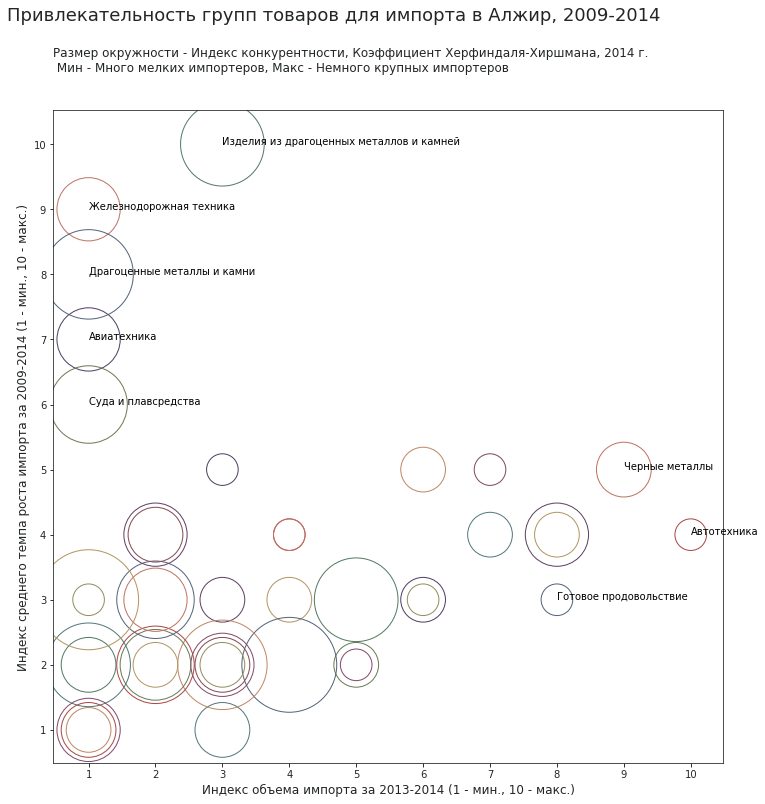

In [325]:
plot_table.product_group = plot_table.product_group.str.capitalize()



plt.figure(figsize = (12, 12))

keycolor = "#232626"
matplotlib.rc('axes', edgecolor=keycolor)
palette23 = ['#aa4747','#bf7265','#b29563','#54637a','#603f63','#824a53','#54787a',
            '#918e5f','#bf8765','#4e3f63','#824a6b','#547a63','#6b7a54']
colors = palette23
plt.scatter(plot_table["volume_index"],
            plot_table["change_index"],
            s=plot_table["herf_index"]*1000,
            c="None",
            edgecolors = palette23,
            alpha = 1)

plt.ylabel("Индекс среднего темпа роста импорта за 2009-2014 (1 - мин., 10 - макс.)", color=keycolor,
           fontsize=12)
plt.xlabel("Индекс объема импорта за 2013-2014 (1 - мин., 10 - макс.)", color=keycolor,
           fontsize=12)

# plt.legend()

for i, row in plot_table.loc[plot_table.volume_index > 5,:].drop_duplicates("change_index").iterrows():
    plt.annotate(row["product_group"],xy=(row["volume_index"],row["change_index"]))

for i, row in plot_table.loc[plot_table.change_index > 5,:].drop_duplicates("change_index").iterrows():
    plt.annotate(row["product_group"],xy=(row["volume_index"],row["change_index"]))


plt.xticks(range(1, 11), color=keycolor)
plt.yticks(range(1, 11), color=keycolor)
plt.suptitle("Привлекательность групп товаров для импорта в Алжир, 2009-2014",
            y=1.0001 , x = 0.45, fontsize=18,
            color=keycolor)

plt.title("Размер окружности - Индекс конкурентности, Коэффициент Херфиндаля-Хиршмана, 2014 г.\n Мин - Много мелких импортеров, Макс - Немного крупных импортеров",
            y=1.05 , x = 0,
             loc = "left", fontsize=12,
            color=keycolor)

plt.show()

### Структура базы данных
Ниже представлены детали дизайна таблиц входящих в базу данных comtrade

Общая структура базы данных

In [ ]:
comtrade=> \d+
                                        List of relations
 Schema |               Name               |   Type   |     Owner     |    Size    | Description 
--------+----------------------------------+----------+---------------+------------+-------------
 public | commodity_codes_en               | table    | dataslap_user | 208 kB     | 
 public | commodity_codes_ru               | table    | dataslap_user | 1072 kB    | 
 public | partners                         | table    | dataslap_user | 48 kB      | 
 public | partners_id_seq                  | sequence | dataslap_user | 8192 bytes | 
 public | quantity_codes                   | table    | dataslap_user | 16 kB      | 
 public | quantity_codes_id_seq            | sequence | dataslap_user | 8192 bytes | 
 public | reporters                        | table    | dataslap_user | 48 kB      | 
 public | reporters_id_seq                 | sequence | dataslap_user | 8192 bytes | 
 public | trade_aggregation_entries        | table    | dataslap_user | 38 MB      | 
 public | trade_aggregation_entries_id_seq | sequence | dataslap_user | 8192 bytes | 
 public | trade_regimes                    | table    | dataslap_user | 16 kB      | 
 public | trade_regimes_id_seq             | sequence | dataslap_user | 8192 bytes | 
(12 rows)



#### Коды наименований товаров (Англ. наименования)

In [ ]:
comtrade=> \d+ commodity_codes_en
                                       Table "public.commodity_codes_en"
     Column     |         Type         | Collation | Nullable | Default | Storage  | Stats target | Description 
----------------+----------------------+-----------+----------+---------+----------+--------------+-------------
 id             | character varying(6) |           | not null |         | extended |              | 
 commodity_name | text                 |           |          |         | extended |              | 
Indexes:
    "commodity_codes_en_pkey" PRIMARY KEY, btree (id)
Referenced by:
    TABLE "trade_aggregation_entries" CONSTRAINT "trade_aggregation_entries_commodity_fkey" FOREIGN KEY (commodity) REFERENCES commodity_codes_en(id)
    

    comtrade=> select * from commodity_codes_en limit 5;
  id  |                     commodity_name                     
------+--------------------------------------------------------
 0402 | Milk and cream, concentrated or containing added sugar
 0403 | Buttermilk, curdled milk and cream or yogurt
 0406 | Cheese and curd.
 0407 | Birds' eggs, in shell, fresh, preserved or cooked.
 0409 | Natural honey.
(5 rows)

comtrade=> select count(*) from commodity_codes_en;
 count 
-------
  1240
(1 row)


#### Коды наименований товаров (Рус. наименования)

In [ ]:
comtrade=> \d+ commodity_codes_ru
                                       Table "public.commodity_codes_ru"
     Column     |         Type         | Collation | Nullable | Default | Storage  | Stats target | Description 
----------------+----------------------+-----------+----------+---------+----------+--------------+-------------
 id             | character varying(6) |           | not null |         | extended |              | 
 commodity_name | text                 |           |          |         | extended |              | 
 product_group  | text                 |           |          |         | extended |              | 
Indexes:
    "commodity_codes_ru_pkey" PRIMARY KEY, btree (id)
    
comtrade=> select * from commodity_codes_ru limit 5;
   id   |                  commodity_name                  |      product_group      
--------+--------------------------------------------------+-------------------------
 01     | Живые животные                                   | прочая сельхозпродукция
 0101   | Лошади, ослы и их помеси                         | прочая сельхозпродукция
 010110 | Чистопородные племенные лошади, ослы и их помеси | прочая сельхозпродукция
 010121 | Чистопородные племенные лошади                   | прочая сельхозпродукция
 010129 | Лошади обычные                                   | прочая сельхозпродукция
(5 rows)


comtrade=> select count(*) from commodity_codes_ru;
 count 
-------
  7422
(1 row)

#### Торговые партнеры

In [ ]:
comtrade=> \d+ partners
                                                   Table "public.partners"
    Column    |  Type   | Collation | Nullable |               Default                | Storage  | Stats target | Description 
--------------+---------+-----------+----------+--------------------------------------+----------+--------------+-------------
 id           | integer |           | not null | nextval('partners_id_seq'::regclass) | plain    |              | 
 partner_name | text    |           |          |                                      | extended |              | 
Indexes:
    "partners_pkey" PRIMARY KEY, btree (id)
    "partners_partner_name_key" UNIQUE CONSTRAINT, btree (partner_name)
Referenced by:
    TABLE "trade_aggregation_entries" CONSTRAINT "trade_aggregation_entries_partner_fkey" FOREIGN KEY (partner) REFERENCES partners(id)


    
comtrade=> select * from partners limit 5;
 id  |       partner_name       
-----+--------------------------
   0 | World
   4 | Afghanistan
 472 | Africa CAMEU region, nes
   8 | Albania
  12 | Algeria
(5 rows)

comtrade=> select count(*) from partners;
 count 
-------
   292
(1 row)


#### Докладывающие страны

In [ ]:
comtrade=> \d+ reporters
                                                    Table "public.reporters"
    Column     |  Type   | Collation | Nullable |                Default                | Storage  | Stats target | Description 
---------------+---------+-----------+----------+---------------------------------------+----------+--------------+-------------
 id            | integer |           | not null | nextval('reporters_id_seq'::regclass) | plain    |              | 
 reporter_name | text    |           |          |                                       | extended |              | 
Indexes:
    "reporters_pkey" PRIMARY KEY, btree (id)
    "reporters_reporter_name_key" UNIQUE CONSTRAINT, btree (reporter_name)
Referenced by:
    TABLE "trade_aggregation_entries" CONSTRAINT "trade_aggregation_entries_reporter_fkey" FOREIGN KEY (reporter) REFERENCES reporters(id)

    
comtrade=> select * from reporters limit 5;
 id | reporter_name 
----+---------------
  4 | Afghanistan
  8 | Albania
 12 | Algeria
 20 | Andorra
 24 | Angola
(5 rows)

comtrade=> select count(*) from reporters;
 count 
-------
   254
(1 row)

#### Коды количества торговли

In [ ]:
comtrade=> \d+ quantity_codes
                                                    Table "public.quantity_codes"
    Column     |  Type   | Collation | Nullable |                  Default                   | Storage  | Stats target | Description 
---------------+---------+-----------+----------+--------------------------------------------+----------+--------------+-------------
 id            | integer |           | not null | nextval('quantity_codes_id_seq'::regclass) | plain    |              | 
 quantity_name | text    |           |          |                                            | extended |              | 
Indexes:
    "quantity_codes_pkey" PRIMARY KEY, btree (id)
    "quantity_codes_quantity_name_key" UNIQUE CONSTRAINT, btree (quantity_name)
Referenced by:
    TABLE "trade_aggregation_entries" CONSTRAINT "trade_aggregation_entries_quantity_code_fkey" FOREIGN KEY (quantity_code) REFERENCES quantity_codes(id)


    
comtrade=> select * from quantity_codes limit 5;
 id |    quantity_name    
----+---------------------
  8 | Weight in kilograms
  1 | No Quantity
  7 | Volume in litres
  5 | Number of items
  6 | Number of pairs
(5 rows)

comtrade=> select count(*) from quantity_codes;
 count 
-------
    11
(1 row)



#### Торговые режимы

In [ ]:
comtrade=> \d+ trade_regimes
                                                      Table "public.trade_regimes"
      Column       |  Type   | Collation | Nullable |                  Default                  | Storage  | Stats target | Description 
-------------------+---------+-----------+----------+-------------------------------------------+----------+--------------+-------------
 id                | integer |           | not null | nextval('trade_regimes_id_seq'::regclass) | plain    |              | 
 trade_regime_name | text    |           |          |                                           | extended |              | 
Indexes:
    "trade_regimes_pkey" PRIMARY KEY, btree (id)
    "trade_regimes_trade_regime_name_key" UNIQUE CONSTRAINT, btree (trade_regime_name)
Referenced by:
    TABLE "trade_aggregation_entries" CONSTRAINT "trade_aggregation_entries_trade_regime_fkey" FOREIGN KEY (trade_regime) REFERENCES trade_regimes(id)


comtrade=> select * from trade_regimes limit 5;
 id | trade_regime_name 
----+-------------------
  1 | Import
  2 | Export
  4 | re-Import
  3 | re-Export
(4 rows)


#### Данные торговой деятельности из API

In [ ]:
comtrade=> \d+ trade_aggregation_entries
                                                             Table "public.trade_aggregation_entries"
       Column       |         Type         | Collation | Nullable |                        Default                        | Storage  | Stats target | Description 
--------------------+----------------------+-----------+----------+-------------------------------------------------------+----------+--------------+-------------
 id                 | bigint               |           | not null | nextval('trade_aggregation_entries_id_seq'::regclass) | plain    |              | 
 pf_code            | character varying(6) |           |          |                                                       | extended |              | 
 year               | integer              |           |          |                                                       | plain    |              | 
 period             | integer              |           |          |                                                       | plain    |              | 
 period_description | text                 |           |          |                                                       | extended |              | 
 aggregation_level  | integer              |           |          |                                                       | plain    |              | 
 trade_regime       | integer              |           | not null |                                                       | plain    |              | 
 reporter           | integer              |           | not null |                                                       | plain    |              | 
 partner            | integer              |           | not null |                                                       | plain    |              | 
 commodity          | character varying(6) |           | not null |                                                       | extended |              | 
 quantity_code      | integer              |           | not null |                                                       | plain    |              | 
 trade_quantity     | bigint               |           |          |                                                       | plain    |              | 
 net_weight         | bigint               |           |          |                                                       | plain    |              | 
 trade_value        | bigint               |           |          |                                                       | plain    |              | 
Indexes:
    "trade_aggregation_entries_pkey" PRIMARY KEY, btree (id)
    "_trade_entry" UNIQUE CONSTRAINT, btree (period, trade_regime, reporter, partner, commodity)
Foreign-key constraints:
    "trade_aggregation_entries_commodity_fkey" FOREIGN KEY (commodity) REFERENCES commodity_codes_en(id)
    "trade_aggregation_entries_partner_fkey" FOREIGN KEY (partner) REFERENCES partners(id)
    "trade_aggregation_entries_quantity_code_fkey" FOREIGN KEY (quantity_code) REFERENCES quantity_codes(id)
    "trade_aggregation_entries_reporter_fkey" FOREIGN KEY (reporter) REFERENCES reporters(id)
    "trade_aggregation_entries_trade_regime_fkey" FOREIGN KEY (trade_regime) REFERENCES trade_regimes(id)
 


comtrade=> select * from trade_aggregation_entries limit 5;
 id | pf_code | year | period | period_description | aggregation_level | trade_regime | reporter | partner | commodity | quantity_code | trade_quantity | net_weight | trade_value 
----+---------+------+--------+--------------------+-------------------+--------------+----------+---------+-----------+---------------+----------------+------------+-------------
  1 | H2      | 2016 |   2016 | 2016               |                 4 |            1 |        4 |       0 | 0402      |             8 |       46524900 |   46524900 |    39099117
  2 | H2      | 2016 |   2016 | 2016               |                 4 |            1 |        4 |      56 | 0402      |             8 |         243459 |     243459 |      254254
  3 | H2      | 2016 |   2016 | 2016               |                 4 |            1 |        4 |     156 | 0402      |             8 |         159285 |     159285 |      110752
  4 | H2      | 2016 |   2016 | 2016               |                 4 |            1 |        4 |     208 | 0402      |             8 |          77958 |      77958 |       91419
  5 | H2      | 2016 |   2016 | 2016               |                 4 |            1 |        4 |     251 | 0402      |             8 |        2233348 |    2233348 |     1934260
(5 rows)

comtrade=> select count(*) from trade_aggregation_entries;
 count  
--------
 364269
(1 row)
